<a href="https://colab.research.google.com/github/supernovaeee/siamese_nn/blob/main/Siamese_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow opencv-python matplotlib

In [ ]:
# !pip install -U scikit-learn

## 1.2 Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import glob
import string
import re

In [2]:
# Import tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.utils import Progbar
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# tf.config.list_physical_devices("GPU")

## 1.3 Create Folder Structures

In [3]:
# set up paths
POS_PATH = os.path.join('drive', 'MyDrive','FaceID','data', 'positive')
NEG_PATH = os.path.join('drive', 'MyDrive','FaceID','data', 'negative')
ANC_PATH = os.path.join('drive', 'MyDrive','FaceID','data', 'anchor')

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# https://vis-www.cs.umass.edu/lfw/

In [ ]:
# # uncompress tar LFW dataset
# !tar -xf lfw.tgz

In [ ]:


# # Define the letters to check
# letters_to_check = string.ascii_uppercase[2::2]  # 'C', 'E', 'G', ...

# # Move LFW images to the following repo (data/negative)
# for file in os.listdir('FaceID/data/negative'):
#     for letter in letters_to_check:
#         if file.startswith(letter):
#             EX_PATH = os.path.join('FaceID/data/negative', file)
#             NEW_PATH = os.path.join(ANC_PATH, file)
#             os.renames(EX_PATH, NEW_PATH)
#             break  # Break the loop if a match is found


In [ ]:
# os.listdir(POS_PATH)

In [ ]:


# # Move images from anchor to positive if their filenames end with even numbers
# for file in os.listdir(POS_PATH):
#     if re.match('.*\_[01][012][0123456789][02468]\.jpg$', file):
#         EX_PATH = os.path.join(POS_PATH, file)
#         NEW_PATH = os.path.join(ANC_PATH, file)
#         os.renames(EX_PATH, NEW_PATH)


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [ ]:
# First, ensure that the image files are correctly stored into anchor, positive, and negative folders
# The anchor and positive images should refer to the same person, while negative is for remaining datasets
# Split a person's images into anchor and positive

In [ ]:
# document_files = os.listdir(POS_PATH)
# document_files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Get all filenames in the document directory
document_files = os.listdir(ANC_PATH)

# Extract unique names from the document filenames
names = []
for filename in document_files:
    parts = filename.split('_')
    if len(parts) == 3:
        # Format: FirstName_LastName_0002.jpg
        name = '_'.join(parts[:2]) + '_'
    elif len(parts) == 2:
        # Format: FirstName_0002.jpg
        name = parts[0] + '_'
    else:
        continue  # Skip files with unexpected format

    names.append(name)

# Remove duplicates from the names list
names = list(set(names))


In [ ]:
len(names)

703

In [7]:
# Randomly select names from the available names list
# num_names = len(names) - 1
selected_names = random.sample(names, 300)


# Create empty anchor and positive datasets
anchor_list = []
positive_list = []
negative = tf.data.Dataset.from_tensor_slices([""])

# Load images from anchor and positive folders and pair them
for i, name in enumerate(selected_names):
    anchor_files = glob.glob(ANC_PATH + f'/{name}*.jpg')
    positive_files = glob.glob(POS_PATH + f'/{name}*.jpg')

    anchor_num = len(anchor_files)
    positive_num = len(positive_files)

    if (anchor_num > positive_num):
      # cycle through the filenames of the most abundant (if anchor files is more abundant than positive files for this name)
      for i in range(anchor_num):
        positive_item = positive_files[i % positive_num] # modulo operator makes sure the index used for positive_files never goes out of bounds. It will cycle back to zero (and increment from zero) once the index reaches a multiple of the list's len()
        anchor_item = anchor_files[i]

        # Append the datasets to anchor and positive
        anchor_list.append(anchor_item)
        positive_list.append(positive_item)
    else:
      # cycle through the filenames of the most abundant (else, if positive files is more abundant than anchor files for this name, or they are equal)
      for i in range(positive_num):
        anchor_item = anchor_files[i % anchor_num] # modulo operator makes sure the index used for anchor_files never goes out of bounds. It will cycle back to zero (and increment from zero) once the index reaches a multiple of the list's len()
        positive_item = positive_files[i]
        # Append the datasets to anchor and positive
        anchor_list.append(anchor_item)
        positive_list.append(positive_item)

# Turn anchor and positive list into tf.data.Dataset (tensorflow dataset(?))
anchor = tf.data.Dataset.from_tensor_slices(anchor_list)
positive = tf.data.Dataset.from_tensor_slices(positive_list)

negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(len(anchor)) # take the length of anchor since length of either one is the same.



In [8]:
len(positive)

715

In [ ]:
# # Print the elements of the paired datasets -- FOR CHECKING
# num_elements_to_show = 30  # Specify the number of elements to show
# anchor_samples = anchor.take(num_elements_to_show)
# positive_samples = positive.take(num_elements_to_show)

# for a, p in tf.data.Dataset.zip((anchor_samples, positive_samples)):
#     print("Anchor:", a)
#     print("Positive:", p)

In [ ]:
# # Print the elements of the paired datasets -- FOR CHECKING
# num_elements_to_show = 30  # Specify the number of elements to show
# anchor_samples = anchor.take(num_elements_to_show)
# negative_samples = negative.take(num_elements_to_show)

# for a, p in tf.data.Dataset.zip((anchor_samples, negative_samples)):
#     print("Anchor:", a)
#     print("Negative:", p)

In [ ]:
# # Take a look at the anchor dataset -- FOR CHECKING
# dir_test = anchor.as_numpy_iterator()

In [ ]:
# print(dir_test.next()) -- FOR CHECKING

## 3.2 Preprocessing - Scale and Resize

In [9]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
#
    # Return image
    return img

In [10]:
def process(file_path):

 # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    return img

In [ ]:
# img = preprocess('drive/MyDrive/FaceID/data/anchor/Mick_Jagger_0002.jpg') -- FOR CHECKING

In [ ]:
# x = process('drive/MyDrive/FaceID/data/anchor/Mick_Jagger_0002.jpg') -- FOR CHECKING
# # Display the image using Matplotlib
# plt.imshow(x)
# plt.axis('off')  # Remove axis ticks
# plt.show()

In [ ]:
# # Convert the TensorFlow tensor to a NumPy array for visualization -- FOR CHECKING
# img_np = img.numpy()

# # Display the image using Matplotlib
# plt.imshow(img_np)
# plt.axis('off')  # Remove axis ticks
# plt.show()


In [ ]:
# img.numpy().max() -- FOR CHECKING

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [ ]:
# len(negative)

In [ ]:
# def preprocess(file_path):

#     # Read in image from file path
#     byte_img = tf.io.read_file(file_path)
#     # Load in the image
#     img = tf.io.decode_jpeg(byte_img)

#     # Preprocessing steps - resizing the image to be 100x100x3
#     img = tf.image.resize(img, (100,100))
#     # Scale image to be between 0 and 1
#     img = img / 255.0

#     # Return image
#     return img

In [11]:
# def process(file_path):

#     # Read in image from file path
#     byte_img = tf.io.read_file(file_path)
#     # Load in the image
#     img = tf.io.decode_jpeg(byte_img)

#     return img

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# # Load and preprocess the anchor, positive, and negative images
# anchor_images = [preprocess(path) for path in anchor]
# positive_images = [preprocess(path) for path in positive]
# negative_images = [preprocess(path) for path in negative]

# # Convert the image lists to tensors
# anchor = tf.data.Dataset.from_tensor_slices(anchor_images)
# positive = tf.data.Dataset.from_tensor_slices(positive_images)
# negative = tf.data.Dataset.from_tensor_slices(negative_images)

# # Combine the datasets
# positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
# negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
# data = positives.concatenate(negatives)

# # Continue with the rest of the code for creating the Siamese network and training



In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
data = positives.concatenate(negatives)

In [ ]:
data.element_spec

In [ ]:
# num_elements_to_show = 5  # Specify the number of elements to show
# positive_samples = positives.take(num_elements_to_show)

# for data_point in positive_samples:
#     print(data_point)


In [ ]:
# samples = data.as_numpy_iterator()

In [ ]:
# examples = samples.next()

## 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# res = preprocess_twin(*examples)

In [ ]:
# plt.imshow(res[1])

In [13]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [14]:
len(data)

1430

In [ ]:
# REPLACED - NOT USED
# # Training partition
# train_data = data.take(round(len(data)*.7))
# # train_data = data.take(4)
# print(len(train_data))
# train_data = train_data.batch(16)
# print(len(train_data))
# train_data = train_data.prefetch(8)
# print(len(train_data))

In [ ]:
# REPLACED - NOT USED
# # Testing partition
# test_data = data.skip(round(len(data)*.7))
# # test_data = data.skip(4)
# # test_data = test_data.take(round(len(data)*.3)) # use the dataset that has been skipped the amount of what was taken for train_data
# print(len(test_data))
# test_data = test_data.batch(16)
# print(len(test_data))
# test_data = test_data.prefetch(8)
# print(len(test_data))

In [15]:
# Split the data into training, validation, and testing partitions
train_size = round(len(data) * 0.7)
val_size = round(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

In [16]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

1001
286
143


In [ ]:
train_data.element_spec

(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [17]:
batch_size = 16
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE) # add , drop_remainder=True after batch_size if want to drop remainder
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
len(test_data)

9

In [ ]:
                                                                                                                                      # # Convert tf.data.Dataset to NumPy arrays
# train_data_np = np.array(list(train_data.as_numpy_iterator()))
# val_data_np = np.array(list(val_data.as_numpy_iterator()))

In [ ]:
# train_samples = train_data.as_numpy_iterator()

In [ ]:
# examples = train_samples.next()

In [ ]:
# plt.imshow(examples[0])

In [ ]:
# test_data_samples = test_data.as_numpy_iterator()
# examples = train_samples.next()


In [ ]:
# plt.imshow(examples[1])

# 4. Model Engineering

In [19]:
def make_embedding():
  inp = Input(shape=(100,100,3), name='input_image')

  # First block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # Second block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # Third block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # Final embedding block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [20]:
embedding = make_embedding()

In [21]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [22]:
# Siamese L1 Distance class -- possible to change to equillibrium distance
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [23]:
l1 = L1Dist()

In [24]:
def make_siamese_model():

  # Anchor image input in the network
  input_image = Input(name='input_img', shape=(100,100,3))

  # Validation image in the network
  validation_image = Input(name='validation_img', shape=(100,100,3))

  # Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [25]:
siamese_model = make_siamese_model()

In [26]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
import tf.keras.backend as K
# Equillibrium Distance class
def equillibrium_distance(vectors):
  v1, v2 = vectors
  sum_square = K.sum(K.square(v1 - v2), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))


In [ ]:
# Function to create the Siamese Neural Network model
def create_siamese_model(learning_rate=1e-4):

     # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    siamese_model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

    # Compile the model with the loss function
    siamese_model.compile(loss='binary_crossentropy', optimizer='adam')

    return siamese_model

In [ ]:
# from tensorflow.keras.layers import Lambda
# # Function to create the Siamese Neural Network model
# def create_siamese_model(learning_rate=1e-4):

#      # Anchor image input in the network
#     input_image = Input(name='input_img', shape=(100, 100, 3))

#     # Validation image in the network
#     validation_image = Input(name='validation_img', shape=(100, 100, 3))

#     embedded_anchor = embedding(input_image)
#     embedded_val = embedding(validation_image)

#     # Distance
#     distance = Lambda(equillibrium_distance, output_shape=(1,))([embedded_anchor, embedded_val])

#     # Classification layer
#     classifier = Dense(1, activation='sigmoid')(distance)

#     siamese_model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

#     # Compile the model with the loss function
#     siamese_model.compile(loss='binary_crossentropy', optimizer='adam')

#     return siamese_model

In [ ]:
import tensorflow_datasets as tfds
train_data.element_spec

In [ ]:
# Extract the labels from train_data and convert them to a NumPy array
y_train = np.array(list(train_data.map(lambda anchor, sample, label: label).as_numpy_iterator()))
# Extract the labels from val_data and convert them to a NumPy array
y_val = np.array(list(val_data.map(lambda anchor, sample, label: label).as_numpy_iterator()))
print(len(y_train))
print(len(y_val))
print(len(train_data))
print(len(val_data))

# Wrap the model creation function in KerasClassifier for use with scikit-learn
model = KerasClassifier(build_fn=create_siamese_model, verbose=0)

# Define hyperparameter grid for grid search
param_grid = {
    'learning_rate': [1e-4, 1e-3],
    'batch_size': [16, 32],
    'dropout_rate': [0.2, 0.4, 0.6],
    'optimizer': ['adam', 'adamax', 'resprop']
}
# Perform GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')

# Fit the grid search on the data with labels (y_train) and validation data (val_data)
grid_result = grid.fit(train_data, y_train, validation_data=(val_data, y_val))

# Get the best hyperparameters from the search
best_learning_rate = grid_result.best_params_['learning_rate']
best_batch_size = grid_result.best_params_['batch_size']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_optimizer = grid_result.best_params_['optimizer']

In [ ]:
def extract_labels(data_generator):
  labels = np.array([label for _, _, label in data.as_numpy_iterator()])
  return labels

y_train = extract_labels(train_data)
y_val = extract_labels(val_data)

train_data = train_data.map(lambda anchor, sample, label: (anchor / 255.0, sample / 255.0, label))
val_data = val_data.map(lambda anchor, sample, label: (anchor / 255.0, sample / 255.0, label))

# Wrap the model creation function in KerasClassifier for use with scikit-learn
model = KerasClassifier(build_fn=create_siamese_model, verbose=0)

# Define hyperparameter grid for grid search
param_grid = {
    'learning_rate': [1e-4, 1e-3],
    'batch_size': [16, 32],
    'dropout_rate': [0.2, 0.4, 0.6],
    'optimizer': ['adam', 'adamax', 'resprop']
}

# Perform GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')

# Fit the grid search on the data with labels (y_train) and validation data (val_data)
grid_result = grid.fit(train_data, y_train, validation_data=val_data)


# Get the best hyperparameters from the search
best_learning_rate = grid_result.best_params_['learning_rate']
best_batch_size = grid_result.best_params_['batch_size']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_optimizer = grid_result.best_params_['optimizer']

## 4.1 Build Embedding Layer

In [ ]:
 # def make_embedding():
#     inp = Input(shape=(100,100,3), name='input_image')

#     # First block
#     c1 = Conv2D(64, (10,10), activation='relu')(inp)
#     m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

#     # Second block
#     c2 = Conv2D(128, (7,7), activation='relu')(m1)
#     m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

#     # Third block
#     c3 = Conv2D(128, (4,4), activation='relu')(m2)
#     m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

#     # Final embedding block
#     c4 = Conv2D(256, (4,4), activation='relu')(m3)
#     f1 = Flatten()(c4)
#     d1 = Dense(4096, activation='sigmoid')(f1)

#     return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
# embedding = make_embedding()

In [ ]:
# embedding.summary()

# 5. Training

## 5.1 Setup Loss and Optimizer

In [27]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [28]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Build Train Step Function

In [ ]:
# @tf.function
# def train_step(batch):

#     # Record all of our operations
#     with tf.GradientTape() as tape:
#         # Get anchor and positive/negative image
#         X = batch[:2]
#         # Get label
#         y = batch[2]

#         # Forward pass
#         yhat = siamese_model(X, training=True)
#         # Calculate loss
#         loss = binary_cross_loss(y, yhat)


#     # # Calculate accuracy
#     # accuracy = tf.keras.metrics.binary_accuracy(y, yhat)

#     # # Update the accuracy lists
#     # train_accuracy.append(accuracy)

#     # Calculate gradients
#     grad = tape.gradient(loss, siamese_model.trainable_variables)

#     # Calculate updated weights and apply to siamese model
#     opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

#     # Return loss
#     return loss

In [29]:
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.3 Build Training Loop

In [ ]:
# def train(data, EPOCHS):
#     # Lists to store loss for plotting
#     train_losses = []

#     # Loop through epochs
#     for epoch in range(1, EPOCHS+1):
#         print('\n Epoch{}/{}'.format(epoch, EPOCHS))
#         progbar = Progbar(len(data))

#         # Variable to store total loss in this epoch
#         total_loss = 0.0

#         # Loop through each batch
#         for idx, batch in enumerate(data):
#             # Run train step and get the loss
#             loss = train_step(batch).numpy()

#             # Update total loss for this epoch
#             total_loss += loss

#             # Print the loss value
#             print("Loss: ", loss)
#             progbar.update(idx + 1)

#         # Calculate average loss for this epoch
#         epoch_loss = total_loss / len(data)
#         train_losses.append(epoch_loss)

#     # Plot the loss
#     plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()


In [30]:
# Training function with validation
def train_with_validation(train_data, val_data, EPOCHS):
    train_losses = []  # To store training losses
    val_losses = []    # To store validation losses

    for epoch in range(1, EPOCHS+1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(train_data))
        batches = 0  # To track the number of batches processed during training

        # Training loop
        for idx, batch in enumerate(train_data):
            loss = train_step(batch).numpy()
            train_losses.append(loss)
            progbar.update(idx + 1)
            batches += 1

        # Validation loop
        val_loss = 0.0
        for idx, batch in enumerate(val_data):
            val_loss += train_step(batch).numpy()
        val_loss /= len(val_data)
        val_losses.extend([val_loss] * batches)  # Extend the list to match train_losses

        # Print training and validation losses
        print(f'\nTraining Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

    # Plot the training and validation losses
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## 5.4 Train the model

In [31]:
EPOCHS = 50


Epoch 1/50
63/63 [==============================] - 249s 813ms/step

Training Loss: 0.6917017698287964, Validation Loss: 0.6938136319319407

Epoch 2/50
63/63 [==============================] - 13s 204ms/step

Training Loss: 0.6955448389053345, Validation Loss: 0.6869785288969675

Epoch 3/50
63/63 [==============================] - 13s 200ms/step

Training Loss: 0.6364138126373291, Validation Loss: 0.700665596458647

Epoch 4/50
63/63 [==============================] - 12s 197ms/step

Training Loss: 0.6856966614723206, Validation Loss: 0.6896028485563066

Epoch 5/50
63/63 [==============================] - 12s 198ms/step

Training Loss: 0.6697008609771729, Validation Loss: 0.6856571469042037

Epoch 6/50
63/63 [==============================] - 12s 198ms/step

Training Loss: 0.6956473588943481, Validation Loss: 0.6933004293176863

Epoch 7/50
63/63 [==============================] - 13s 200ms/step

Training Loss: 0.6942980289459229, Validation Loss: 0.6824644439750247

Epoch 8/50
63/63 [=

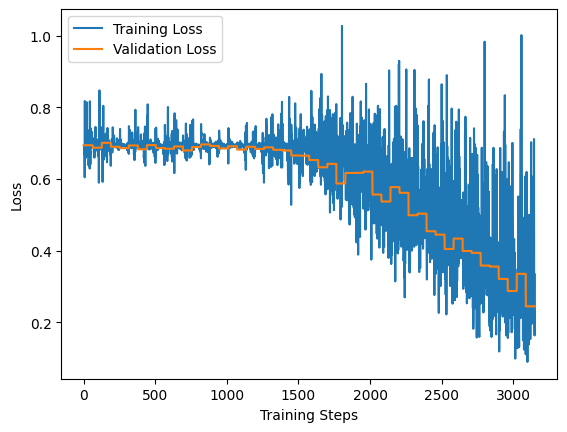

In [32]:
train_with_validation(train_data, val_data, EPOCHS)

# 6. Evaluate Model

## 6.1 Import Metrics

In [34]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [35]:
# get entire test data

# Initialize empty lists
test_input_list = []
test_val_list = []
y_true_list = []
# Iterate over the test_data and collect the data

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    test_input_list.append(test_input)
    test_val_list.append(test_val)
    y_true_list.append(y_true)

# Concatenate the collected data into numpy arrays
test_input = np.concatenate(test_input_list)
test_val = np.concatenate(test_val_list)
y_true = np.concatenate(y_true_list)

In [36]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

5/5 [==============================] - 2s 225ms/step


array([[7.75453210e-01],
       [8.24438751e-01],
       [9.99163032e-01],
       [7.35534787e-01],
       [5.82272828e-01],
       [4.28958148e-01],
       [8.60723794e-01],
       [2.06652749e-02],
       [6.89121056e-03],
       [1.90558210e-01],
       [1.42229241e-04],
       [2.86977232e-01],
       [8.75934899e-01],
       [9.66016829e-01],
       [8.85616094e-02],
       [8.59905422e-01],
       [8.73044133e-01],
       [5.35147935e-02],
       [9.65926707e-01],
       [9.39455032e-01],
       [3.81327271e-01],
       [9.61327612e-01],
       [7.26045847e-01],
       [8.71765792e-01],
       [8.18278074e-01],
       [2.34904786e-04],
       [9.53262905e-04],
       [9.64945734e-01],
       [9.86513555e-01],
       [7.69351702e-03],
       [1.13790251e-01],
       [9.05579049e-03],
       [4.56962466e-01],
       [9.70537841e-01],
       [2.67006040e-01],
       [9.95991886e-01],
       [5.49353480e-01],
       [1.14138074e-01],
       [9.87281144e-01],
       [8.38241696e-01],


In [37]:
# Convert predictions to binary values
y_pred = np.where(y_hat > 0.5, 1, 0)
y = np.column_stack((y_pred, y_true))
np.set_printoptions(threshold=np.inf)
print(y)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 

## 6.3 Calculate Metrics

In [38]:
# Recall (Sensitivity) = TP / TP + FN
# Percentage of positive samples correctly predicted (over what is really positive)

# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_pred)

# Return Recall result
m.result().numpy()

0.9220779

In [39]:
# Precision = TP / TP + FP
# Percentage of samples that were properly labeled positives (over positive labelled samples)
# Creating a metric object
m = Precision()

# Calculating the precision value
m.update_state(y_true, y_pred)

# Return Precision result
m.result().numpy()

0.93421054

In [40]:
# Accuracy = TP + TN / All
from sklearn.metrics import accuracy_score

# Compute the accuracy score
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.9230769230769231


In [41]:
# # Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
print("True Negatives: ", tn, "False Positives: ", fp, "\nFalse Negatives: ", fn, "True Positives: ", tp)


True Negatives:  61 False Positives:  5 
False Negatives:  6 True Positives:  71


## 6.4 Visualize Results

Index:  6


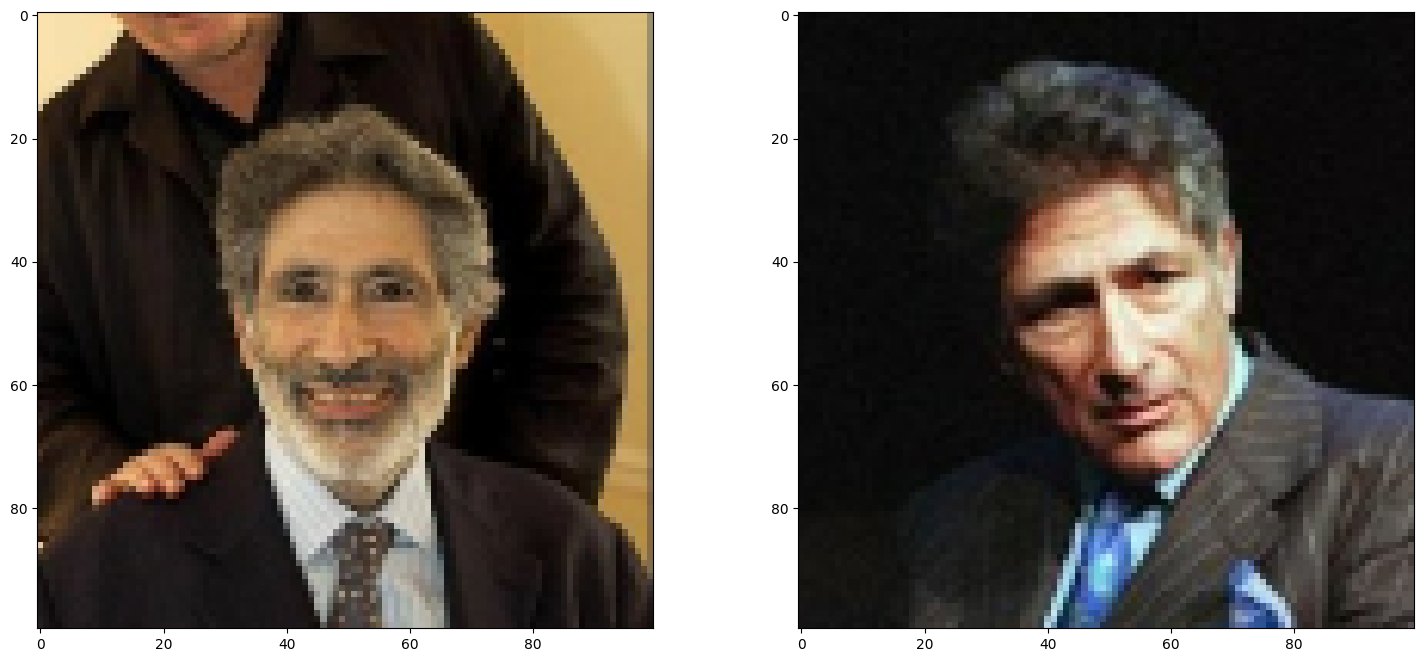

Same Person


In [47]:
# Set plot size
plt.figure(figsize=(18,8))

# Set index
# index = 15
index = random.randint(0,143)
print("Index: ", index)

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[index])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[index])

# Renders cleanly
plt.show()

if (y_pred[index] == 1):
    print("Same Person")
else:
    print("Different Persons")

# 7. Save Model

In [48]:
# Save weights
siamese_model.save('FaceID/siamesemodel.h5')

In [49]:
# Reload model
model = tf.keras.models.load_model('FaceID/siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [50]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

5/5 [==============================] - 1s 148ms/step


array([[7.75453210e-01],
       [8.24438751e-01],
       [9.99163032e-01],
       [7.35534787e-01],
       [5.82272828e-01],
       [4.28958148e-01],
       [8.60723794e-01],
       [2.06652749e-02],
       [6.89121056e-03],
       [1.90558210e-01],
       [1.42229241e-04],
       [2.86977232e-01],
       [8.75934899e-01],
       [9.66016829e-01],
       [8.85616094e-02],
       [8.59905422e-01],
       [8.73044133e-01],
       [5.35147935e-02],
       [9.65926707e-01],
       [9.39455032e-01],
       [3.81327271e-01],
       [9.61327612e-01],
       [7.26045847e-01],
       [8.71765792e-01],
       [8.18278074e-01],
       [2.34904786e-04],
       [9.53262905e-04],
       [9.64945734e-01],
       [9.86513555e-01],
       [7.69351702e-03],
       [1.13790251e-01],
       [9.05579049e-03],
       [4.56962466e-01],
       [9.70537841e-01],
       [2.67006040e-01],
       [9.95991886e-01],
       [5.49353480e-01],
       [1.14138074e-01],
       [9.87281144e-01],
       [8.38241696e-01],


In [51]:
# Display model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

<h1> 8. Real Time Test <h1>


<h2> 8.1 Verification Function <h2>

In [52]:
def verify(model, detection_threshold, verification_threshold):
  # Build results array
  results = []
  for image in os.listdir(os.path.join('application_data', 'verification_images')):
    input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
    validation_img = preprocess(os.path.join('application_data','verification_images', image))

    # Make Predictions
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)

  # Detection Threshold: Metric above which a prediction is considered positive
  detection = np.sum(np.array(results) > detection_threshold)

  # Verification Threshold: Proportion of positive predictions / total positive samples
  verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
  verified = verification > verification_threshold

  return results, verified

<h2> 8.2 OpenCV Real Time Verification  <h2>


In [101]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
